In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings

In [52]:
df = pd.read_csv('train.csv')
print(f"Train shape: {df.shape}")
print("\n=== Información de columnas ===")
df.info()

Train shape: (692500, 21)

=== Información de columnas ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12 


=== Distribución de RENDIMIENTO_GLOBAL ===
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64

Porcentajes:
RENDIMIENTO_GLOBAL
alto          25.36
bajo          24.98
medio-bajo    24.88
medio-alto    24.78
Name: count, dtype: float64


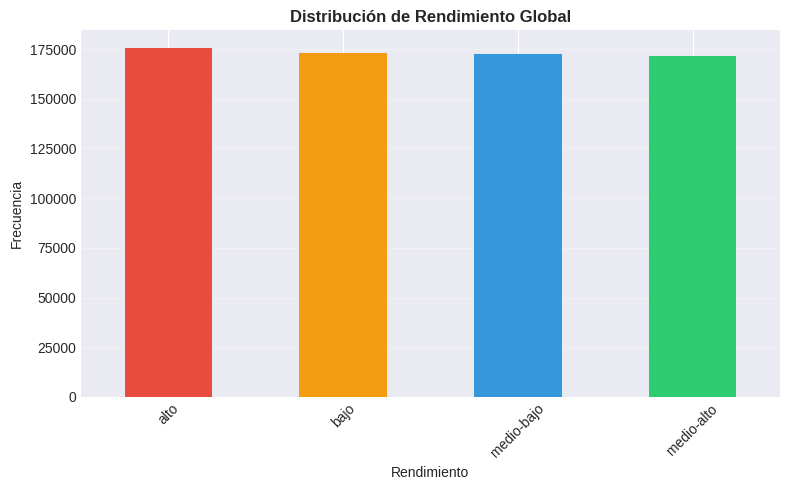

In [53]:
# Distribución de la variable objetivo
print("\n=== Distribución de RENDIMIENTO_GLOBAL ===")
target_counts = df['RENDIMIENTO_GLOBAL'].value_counts()
print(target_counts)
print("\nPorcentajes:")
print((target_counts / len(df) * 100).round(2))

# Visualización simple
plt.figure(figsize=(8, 5))
target_counts.plot(kind='bar', color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
plt.title('Distribución de Rendimiento Global', fontsize=12, fontweight='bold')
plt.xlabel('Rendimiento')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
print("\n=== Valores faltantes en Ttrain por columna ===")
for col in df.columns:
    missing = df[col].isna().sum()
    if missing > 0:
        pct = (missing / len(df)) * 100
        print(f"{col:30s} {missing:5d} ({pct:5.2f}%)")


=== Valores faltantes en Ttrain por columna ===
E_VALORMATRICULAUNIVERSIDAD     6287 ( 0.91%)
E_HORASSEMANATRABAJA           30857 ( 4.46%)
F_ESTRATOVIVIENDA              32137 ( 4.64%)
F_TIENEINTERNET                26629 ( 3.85%)
F_EDUCACIONPADRE               23178 ( 3.35%)
F_TIENELAVADORA                39773 ( 5.74%)
F_TIENEAUTOMOVIL               43623 ( 6.30%)
E_PAGOMATRICULAPROPIO           6498 ( 0.94%)
F_TIENECOMPUTADOR              38103 ( 5.50%)
F_TIENEINTERNET.1              26629 ( 3.85%)
F_EDUCACIONMADRE               23664 ( 3.42%)


In [59]:
df_copy = df.copy()
print(df_copy['E_VALORMATRICULAUNIVERSIDAD'].unique())

['Entre 5.5 millones y menos de 7 millones'
 'Entre 2.5 millones y menos de 4 millones'
 'Entre 4 millones y menos de 5.5 millones' 'Más de 7 millones'
 'Entre 1 millón y menos de 2.5 millones'
 'Entre 500 mil y menos de 1 millón' 'Menos de 500 mil'
 'No pagó matrícula' nan]


In [71]:
def convertir_valor_matricula(valor):
    # Si es NaN, retornar NaN
    if pd.isna(valor):
        return np.nan

    # Si ya es un número, retornarlo tal cual
    if isinstance(valor, (int, float)):
        return float(valor)

    # Si es string, hacer la conversión
    valor_str = str(valor)

    if 'Menos de 500 mil' in valor_str:
        return 250000
    elif 'Entre 500 mil y menos de 1 millón' in valor_str:
        return 750000
    elif 'Entre 1 millón y menos de 2.5 millones' in valor_str:
        return 1750000
    elif 'Entre 2.5 millones y menos de 4 millones' in valor_str:
        return 3250000
    elif 'Entre 4 millones y menos de 5.5 millones' in valor_str:
        return 4750000
    elif 'Entre 5.5 millones y menos de 7 millones' in valor_str:
        return 6250000
    elif 'Más de 7 millones' in valor_str:
        return 7500000
    elif 'No pagó matrícula' in valor_str:
        return 0
    else:
        return np.nan

df_copy['E_VALORMATRICULAUNIVERSIDAD'] = df_copy['E_VALORMATRICULAUNIVERSIDAD'].apply(convertir_valor_matricula)
media_matricula = df_copy['E_VALORMATRICULAUNIVERSIDAD'].mean()
df_copy['E_VALORMATRICULAUNIVERSIDAD'] = df_copy['E_VALORMATRICULAUNIVERSIDAD'].fillna(media_matricula)
print(f"  Media de matrícula: ${media_matricula:,.2f}")

  Media de matrícula: $2,815,800.27


In [73]:
print(df_copy['E_HORASSEMANATRABAJA'].unique())#hay nan

['Menos de 10 horas' '0' 'Más de 30 horas' 'Entre 21 y 30 horas'
 'Entre 11 y 20 horas' nan]


In [74]:
def convertir_horas_trabajadas(valor):
    # Si es NaN, retornar NaN
    if pd.isna(valor):
        return np.nan

    # Si ya es un número, retornarlo tal cual
    if isinstance(valor, (int, float)):
        return float(valor)

    # Convertir a string para procesar
    valor_str = str(valor).strip()

    # Caso: "0"
    if valor_str == "0":
        return 0.0

    # Caso: "Entre X y Y horas"
    if "Entre" in valor_str:
        # Extraer números del rango
        partes = valor_str.replace('Entre ', '').replace(' horas', '').split(' y ')
        try:
            min_val = float(partes[0])
            max_val = float(partes[1])
            return (min_val + max_val) / 2
        except:
            return np.nan

    # Caso: "Más de X horas"
    elif "Más de" in valor_str:
        try:
            return float(valor_str.split(' ')[2])
        except:
            return np.nan

    # Caso: "Menos de X horas"
    elif "Menos de" in valor_str:
        try:
            return float(valor_str.split(' ')[2])
        except:
            return np.nan

    else:
        return np.nan

# Aplicar conversión
df_copy['E_HORASSEMANATRABAJA'] = df_copy['E_HORASSEMANATRABAJA'].apply(convertir_horas_trabajadas)

# Imputar valores faltantes con 0 (asumimos que no trabajan)
df_copy['E_HORASSEMANATRABAJA'] = df_copy['E_HORASSEMANATRABAJA'].fillna(0)

print(f"  Valores únicos: {sorted(df_copy['E_HORASSEMANATRABAJA'].unique())}")


  Valores únicos: [np.float64(0.0), np.float64(10.0), np.float64(15.5), np.float64(25.5), np.float64(30.0)]


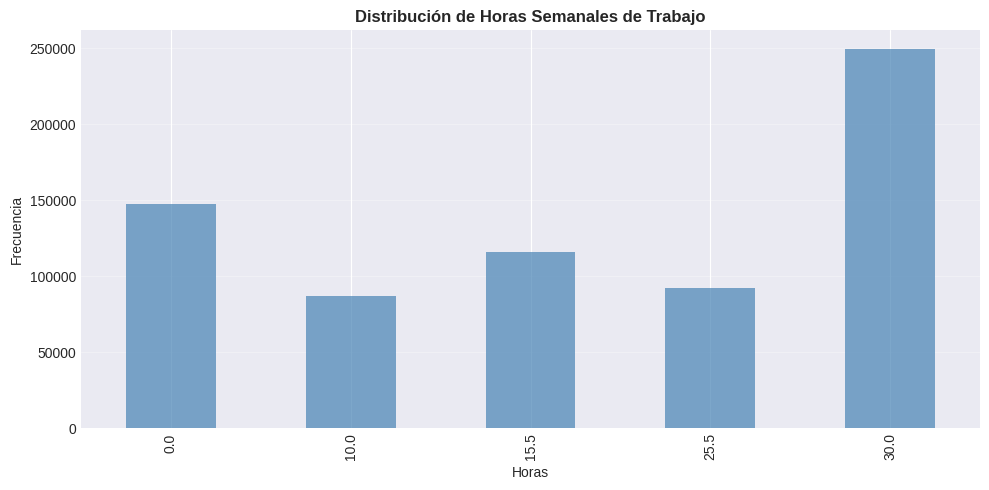

In [76]:
# Visualizar distribución
fig, ax = plt.subplots(figsize=(10, 5))
df_copy['E_HORASSEMANATRABAJA'].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue', alpha=0.7)
ax.set_title('Distribución de Horas Semanales de Trabajo', fontsize=12, fontweight='bold')
ax.set_xlabel('Horas', fontsize=10)
ax.set_ylabel('Frecuencia', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
print(df_copy['F_ESTRATOVIVIENDA'].unique())#existe nan

['Estrato 3' 'Estrato 4' 'Estrato 5' 'Estrato 2' 'Estrato 1' nan
 'Estrato 6' 'Sin Estrato']


In [80]:
estrato_dict = {
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6,
    'Sin Estrato': 0
}

In [82]:
df_copy['F_ESTRATOVIVIENDA'] = df_copy['F_ESTRATOVIVIENDA'].map(estrato_dict)
df_copy['F_ESTRATOVIVIENDA'] = df_copy['F_ESTRATOVIVIENDA'].fillna(0)
print(f"  Valores únicos: {sorted(df_copy['F_ESTRATOVIVIENDA'].unique())}")

  Valores únicos: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]


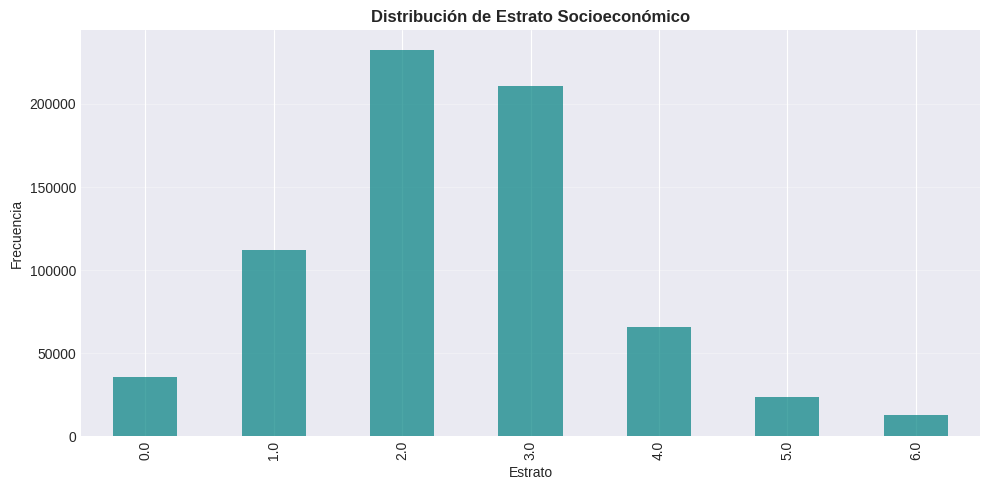

In [83]:
fig, ax = plt.subplots(figsize=(10, 5))
df_copy['F_ESTRATOVIVIENDA'].value_counts().sort_index().plot(kind='bar', ax=ax, color='teal', alpha=0.7)
ax.set_title('Distribución de Estrato Socioeconómico', fontsize=12, fontweight='bold')
ax.set_xlabel('Estrato', fontsize=10)
ax.set_ylabel('Frecuencia', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
# FAMI_TIENEINTERNET
df_copy['F_TIENEINTERNET'] = df_copy['F_TIENEINTERNET'].map({'Si': 1, 'No': 0})
df_copy['F_TIENEINTERNET'] = df_copy['F_TIENEINTERNET'].fillna(0)

In [85]:
# ESTU_PAGOMATRICULAPROPIO
df_copy['E_PAGOMATRICULAPROPIO'] = df_copy['E_PAGOMATRICULAPROPIO'].map({'Si': 1, 'No': 0})
df_copy['E_PAGOMATRICULAPROPIO'] = df_copy['E_PAGOMATRICULAPROPIO'].fillna(0)

In [87]:
print(f"  F_TIENEINTERNET: {df_copy['F_TIENEINTERNET'].unique()}")
print(f"  E_PAGOMATRICULAPROPIO: {df_copy['E_PAGOMATRICULAPROPIO'].unique()}")

  F_TIENEINTERNET: [1. 0.]
  E_PAGOMATRICULAPROPIO: [0. 1.]


In [89]:
# Mapeo ordinal: 1=bajo, 2=medio-bajo, 3=medio-alto, 4=alto
rendimiento_dict = {
    'bajo': 1,
    'medio-bajo': 2,
    'medio-alto': 3,
    'alto': 4
}

In [90]:
df_copy['RENDIMIENTO_GLOBAL'] = df_copy['RENDIMIENTO_GLOBAL'].map(rendimiento_dict)

In [91]:
print("\n=== MAPEO DE RENDIMIENTO_GLOBAL ===")
for label, code in rendimiento_dict.items():
    count = (df_copy['RENDIMIENTO_GLOBAL'] == code).sum()
    pct = (count / len(df_copy)) * 100
    print(f"  {label:12s} -> {code}  ({count:6,} estudiantes, {pct:5.2f}%)")


=== MAPEO DE RENDIMIENTO_GLOBAL ===
  bajo         -> 1  (172,987 estudiantes, 24.98%)
  medio-bajo   -> 2  (172,275 estudiantes, 24.88%)
  medio-alto   -> 3  (171,619 estudiantes, 24.78%)
  alto         -> 4  (175,619 estudiantes, 25.36%)


In [102]:
def to_onehot(x):
    """Convierte array en matriz one-hot"""
    values = np.unique(x)
    indices = np.array([np.where(values == i)[0][0] for i in x])
    return np.eye(len(values))[indices].astype(int)

def replace_column_with_onehot(dataframe, col):
    """Reemplaza una columna con su versión one-hot"""
    assert dataframe[col].isna().sum() == 0, f"La columna {col} tiene valores NaN"

    values = np.unique(dataframe[col])
    k = to_onehot(dataframe[col].values)

    # Crear DataFrame con columnas one-hot
    onehot_df = pd.DataFrame(
        k,
        columns=[f"{col}_{values[i]}" for i in range(k.shape[1])],
        index=dataframe.index
    )

    return onehot_df

In [115]:
print(f"Valores únicos: {df_copy['F_EDUCACIONMADRE'].unique()}")

col_madre = 'F_EDUCACIONMADRE'
df_copy[col_madre] = df_copy[col_madre].fillna('No Aplica')

madre_onehot = replace_column_with_onehot(df_copy[[col_madre]], col_madre)
df_copy = df_copy.join(madre_onehot)
df_copy = df_copy.drop(col_madre, axis=1)

print(f"✓ {madre_onehot.shape[1]} columnas one-hot creadas")

KeyError: 'F_EDUCACIONMADRE'

In [121]:
print(f"Valores únicos: {df_copy['F_EDUCACIONPADRE'].unique()}")

Valores únicos: ['Técnica o tecnológica incompleta' 'Técnica o tecnológica completa'
 'Secundaria (Bachillerato) completa' 'No sabe' 'Primaria completa'
 'Educación profesional completa' 'Educación profesional incompleta'
 'Primaria incompleta' 'Postgrado' nan
 'Secundaria (Bachillerato) incompleta' 'Ninguno' 'No Aplica']


In [123]:
col_padre = 'F_EDUCACIONPADRE'
df_copy[col_padre] = df_copy[col_padre].fillna('No Aplica')

padre_onehot = replace_column_with_onehot(df_copy[[col_padre]], col_padre)
df_copy = df_copy.join(padre_onehot)
df_copy = df_copy.drop(col_padre, axis=1)

In [124]:
print("\n=== Procesando E_PRGM_ACADEMICO ===")
print(f"Programas únicos: {df_copy['E_PRGM_ACADEMICO'].nunique()}")

le = LabelEncoder()
df_copy['E_PRGM_ACADEMICO'] = le.fit_transform(df_copy['E_PRGM_ACADEMICO'])

print(f"✓ Label Encoding aplicado")
print(f"  Rango de valores: {df_copy['E_PRGM_ACADEMICO'].min()} - {df_copy['E_PRGM_ACADEMICO'].max()}")


=== Procesando E_PRGM_ACADEMICO ===
Programas únicos: 948
✓ Label Encoding aplicado
  Rango de valores: 0 - 947


In [126]:
print("\n=== Procesando E_PRGM_DEPARTAMENTO ===")
print(f"Departamentos únicos: {df_copy['E_PRGM_DEPARTAMENTO'].nunique()}")
print(f"Valores: {sorted(df_copy['E_PRGM_DEPARTAMENTO'].unique())}")

col_depto = 'E_PRGM_DEPARTAMENTO'
depto_onehot = replace_column_with_onehot(df_copy[[col_depto]], col_depto)
df_copy = df_copy.join(depto_onehot)
df_copy = df_copy.drop(col_depto, axis=1)


=== Procesando E_PRGM_DEPARTAMENTO ===
Departamentos únicos: 31
Valores: ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTÁ', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'GUAVIARE', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARIÑO', 'NORTE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SAN ANDRES', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE', 'VAUPES']


In [129]:
print(f"\n Dimenciones:")
print(f"   Original: {df.shape}")
print(f"   Procesado: {df_copy.shape}")
print(f"   Nuevas columnas: {df_copy.shape[1] - df.shape[1]}")

print(f"\n VALORES FALTANTES:")
missing_total = df_copy.isna().sum().sum()
if missing_total == 0:
    print(f"   0 valores faltantes - Dataset completamente limpio")
else:
    print(f"  {missing_total} valores faltantes restantes")


 Dimenciones:
   Original: (692500, 21)
   Procesado: (692500, 73)
   Nuevas columnas: 52

 VALORES FALTANTES:
   0 valores faltantes - Dataset completamente limpio


In [130]:
# Verificar qué columnas aún tienen valores faltantes
missing_cols = df_copy.columns[df_copy.isna().any()].tolist()

if len(missing_cols) > 0:
    print(f" Columnas con valores faltantes: {len(missing_cols)}")
    for col in missing_cols:
        missing_count = df_copy[col].isna().sum()
        missing_pct = (missing_count / len(df_copy)) * 100
        print(f"   {col:40s} {missing_count:8,} ({missing_pct:6.2f}%)")

    print("\n Aplicando imputación...")

    # Para cada columna con valores faltantes
    for col in missing_cols:
        # Si es numérica: rellenar con la mediana
        if df_copy[col].dtype in ['int64', 'float64']:
            median_val = df_copy[col].median()
            df_copy[col] = df_copy[col].fillna(median_val)
            print(f"   {col}: imputado con mediana ({median_val})")

        # Si es categórica/object: rellenar con la moda
        elif df_copy[col].dtype == 'object':
            mode_val = df_copy[col].mode()[0] if len(df_copy[col].mode()) > 0 else 'Desconocido'
            df_copy[col] = df_copy[col].fillna(mode_val)
            print(f"   {col}: imputado con moda ({mode_val})")

    # Verificar que ya no queden valores faltantes
    remaining_missing = df_copy.isna().sum().sum()
    print(f"\n Valores faltantes después de limpieza: {remaining_missing}")
else:
    print("No hay columnas con valores faltantes")

No hay columnas con valores faltantes
